In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn; seaborn.set()
from sklearn.metrics import mean_squared_error
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**Loading  Data and study the rows and column values**

In [2]:
data = pd.read_csv("../input/bitcoin_price_Training - Training.csv")
print(data.head(5))
print(data.tail(5))
data.dtypes
data.info()
data.describe()

           Date     Open     High      Low    Close         Volume  \
0  Jul 31, 2017  2763.24  2889.62  2720.61  2875.34    860,575,000   
1  Jul 30, 2017  2724.39  2758.53  2644.85  2757.18    705,943,000   
2  Jul 29, 2017  2807.02  2808.76  2692.80  2726.45    803,746,000   
3  Jul 28, 2017  2679.73  2897.45  2679.73  2809.01  1,380,100,000   
4  Jul 27, 2017  2538.71  2693.32  2529.34  2671.78    789,104,000   

       Market Cap  
0  45,535,800,000  
1  44,890,700,000  
2  46,246,700,000  
3  44,144,400,000  
4  41,816,500,000  
              Date    Open    High     Low   Close Volume     Market Cap
1551  May 02, 2013  116.38  125.60   92.28  105.21      -  1,292,190,000
1552  May 01, 2013  139.00  139.89  107.72  116.99      -  1,542,820,000
1553  Apr 30, 2013  144.00  146.93  134.05  139.00      -  1,597,780,000
1554  Apr 29, 2013  134.44  147.49  134.00  144.54      -  1,491,160,000
1555  Apr 28, 2013  135.30  135.98  132.10  134.21      -  1,500,520,000
<class 'pandas.core.f

,Open,High,Low,Close
count,1556.000000,1556.000000,1556.000000,1556.000000
mean,582.625328,597.992847,567.851446,584.239396
std,523.137312,542.992855,505.877401,525.904442
min,68.500000,74.560000,65.530000,68.430000
25%,254.287500,260.327500,248.835000,254.320000
50%,438.600000,447.560000,430.570000,438.855000
75%,662.437500,674.525000,646.735000,663.402500
max,2953.220000,2999.910000,2840.530000,2958.110000


Date is to be in Date-time format inorder to perform a time series study. In the current dataset the date is stated as an object which  is to be converted by parsing through the read-csv command  

In [3]:
data = pd.read_csv("../input/bitcoin_price_Training - Training.csv",index_col= 'Date')
print(data.head(5)) 
data.info()
data.index = pd.to_datetime(data.index)
print(data.index)
data.head(5)

                 Open     High      Low    Close         Volume  \
Date                                                              
Jul 31, 2017  2763.24  2889.62  2720.61  2875.34    860,575,000   
Jul 30, 2017  2724.39  2758.53  2644.85  2757.18    705,943,000   
Jul 29, 2017  2807.02  2808.76  2692.80  2726.45    803,746,000   
Jul 28, 2017  2679.73  2897.45  2679.73  2809.01  1,380,100,000   
Jul 27, 2017  2538.71  2693.32  2529.34  2671.78    789,104,000   

                  Market Cap  
Date                          
Jul 31, 2017  45,535,800,000  
Jul 30, 2017  44,890,700,000  
Jul 29, 2017  46,246,700,000  
Jul 28, 2017  44,144,400,000  
Jul 27, 2017  41,816,500,000  
<class 'pandas.core.frame.DataFrame'>
Index: 1556 entries, Jul 31, 2017 to Apr 28, 2013
Data columns (total 6 columns):
Open          1556 non-null float64
High          1556 non-null float64
Low           1556 non-null float64
Close         1556 non-null float64
Volume        1556 non-null object
Market Cap    

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2017-07-31,2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
2017-07-30,2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2017-07-29,2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
2017-07-28,2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
2017-07-27,2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


Now sort the dataset from oldest - recent 

In [4]:
data = data.sort_index()
data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,-,"1,500,520,000"
2013-04-29,134.44,147.49,134.00,144.54,-,"1,491,160,000"
2013-04-30,144.00,146.93,134.05,139.00,-,"1,597,780,000"
2013-05-01,139.00,139.89,107.72,116.99,-,"1,542,820,000"
2013-05-02,116.38,125.60,92.28,105.21,-,"1,292,190,000"


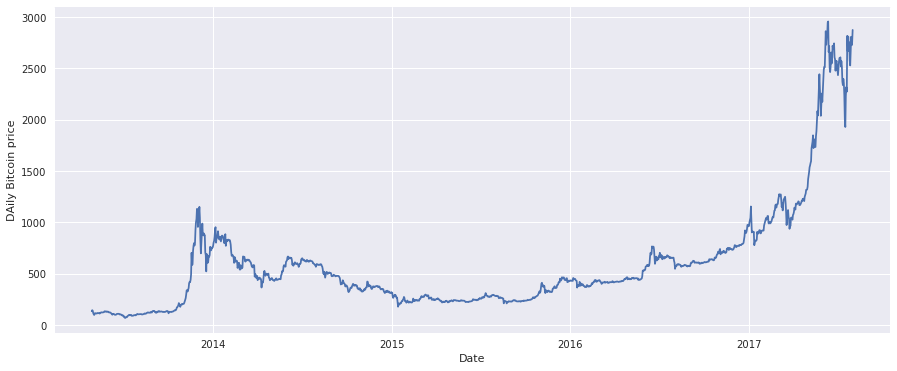

In [5]:
data['Close'].plot()
plt.ylabel("DAily Bitcoin price")

In this model I am trying to predict the Closing price of Bitcoin, and so I create a new object eliminating other columns

In [6]:
data = data['Close']

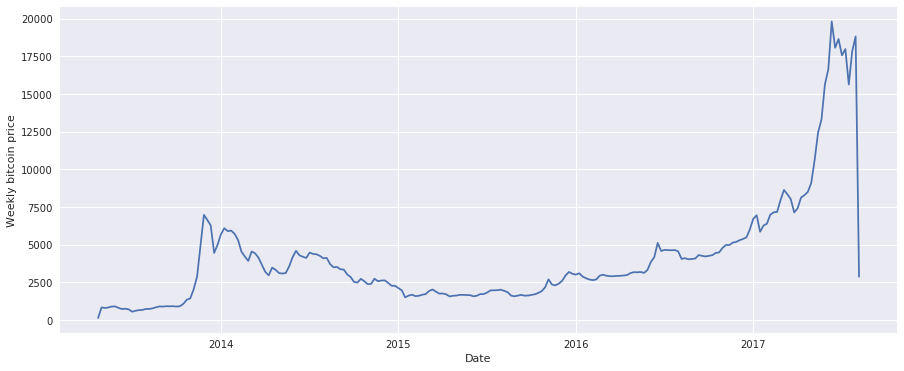

In [7]:
weekly = data.resample('W').sum()
weekly.plot()
plt.ylabel('Weekly bitcoin price')


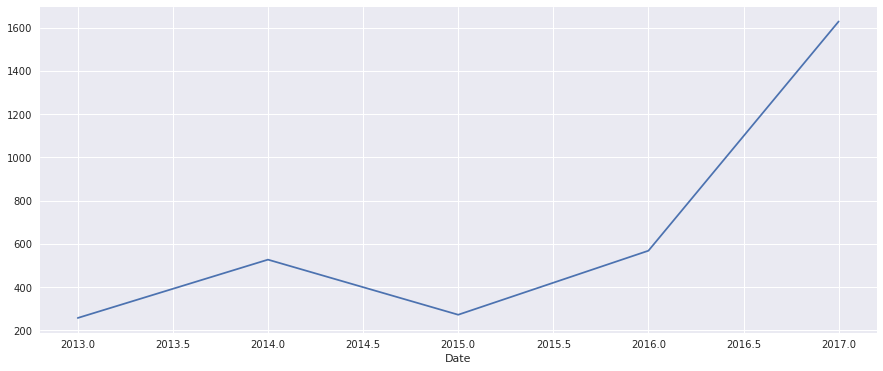

In [8]:
by_year = data.groupby(data.index.year).mean()
by_year.plot()

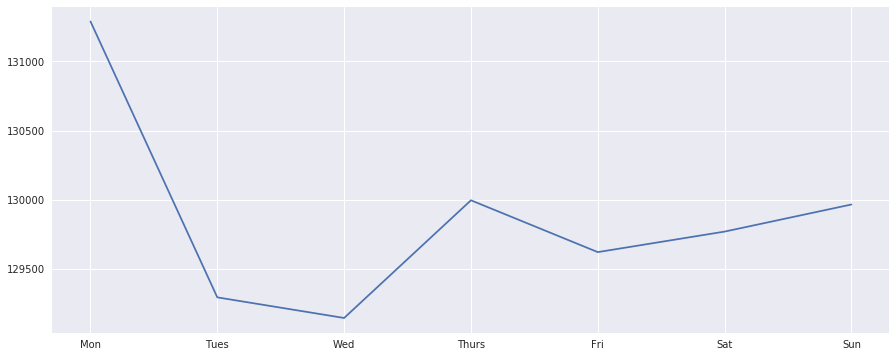

In [9]:
by_weekday = data.groupby(data.index.dayofweek).sum()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot()

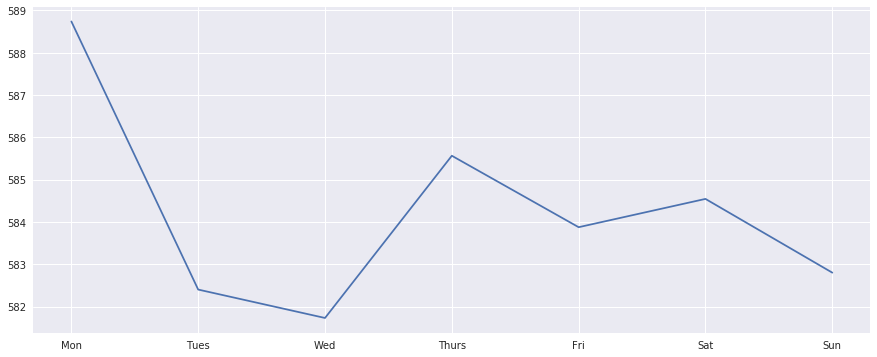

In [10]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot()

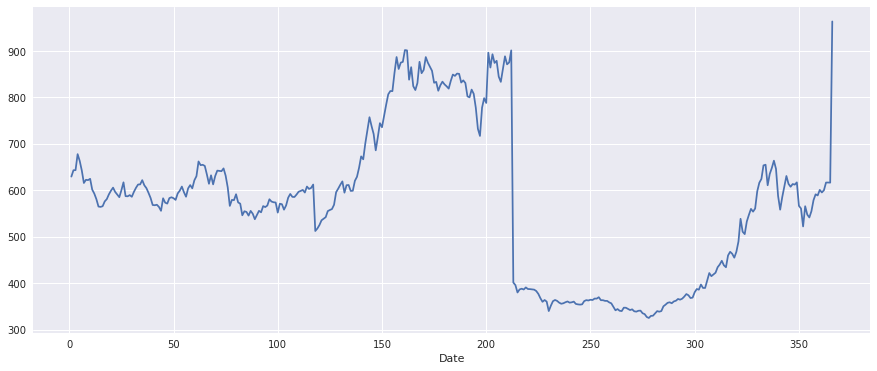

In [11]:
by_day = data.groupby(data.index.dayofyear).mean()
by_day.plot()

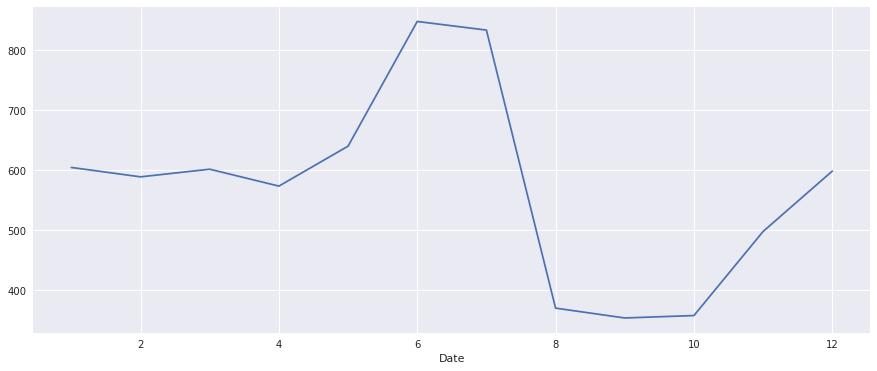

In [12]:
by_month = data.groupby(data.index.month).mean()
by_month.plot()

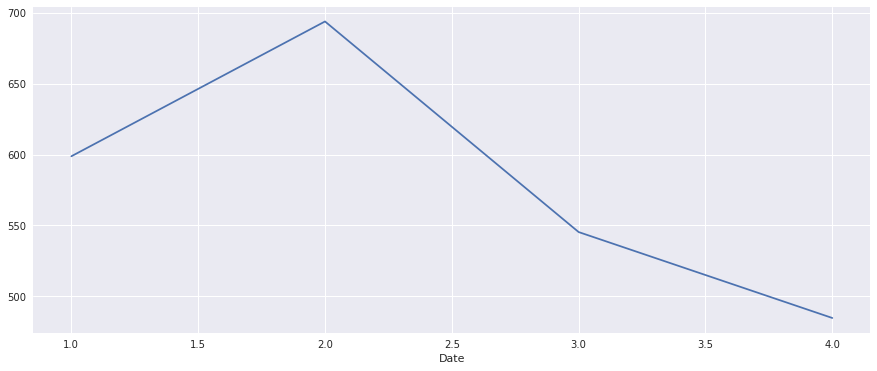

In [13]:
by_quarter = data.groupby(data.index.quarter).mean()
by_quarter.plot()

Date
1    Axes(0.125,0.2;0.775x0.68)
2    Axes(0.125,0.2;0.775x0.68)
3    Axes(0.125,0.2;0.775x0.68)
4    Axes(0.125,0.2;0.775x0.68)
Name: Close, dtype: object

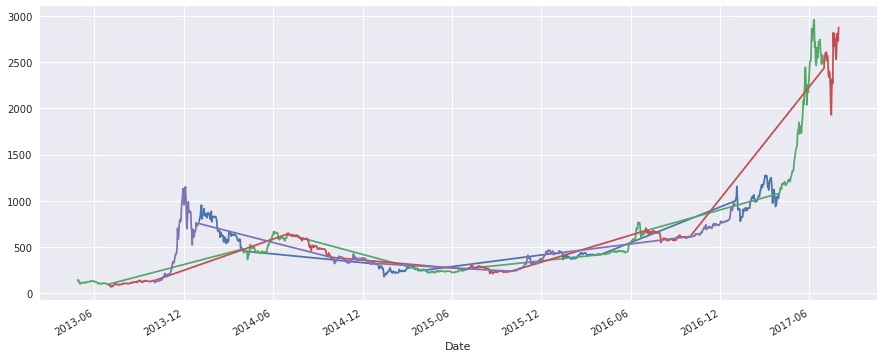

In [14]:
by_quarter = data.groupby(data.index.quarter)
by_quarter.plot()

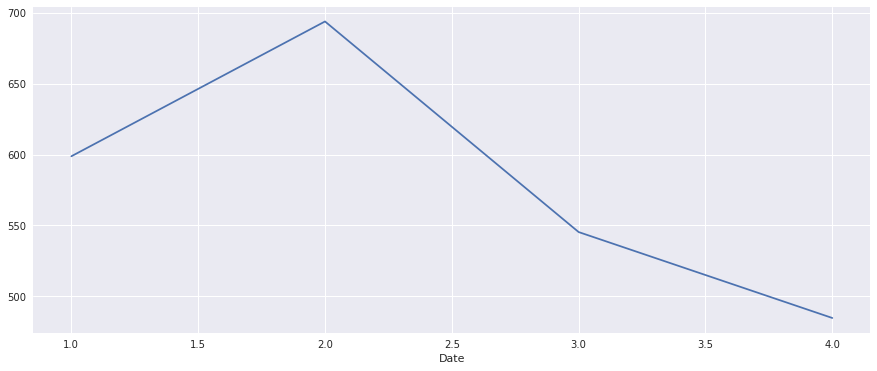

In [15]:
by_quarter_overall = data.groupby(data.index.quarter).mean()
by_quarter_overall.plot()

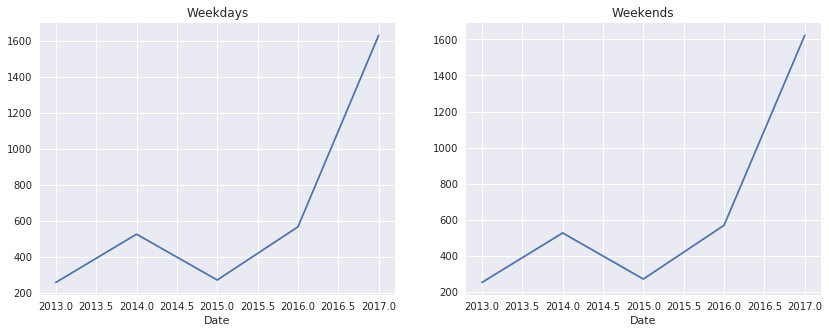

In [16]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.year]).mean()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays')
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends')

In [17]:
ts = data

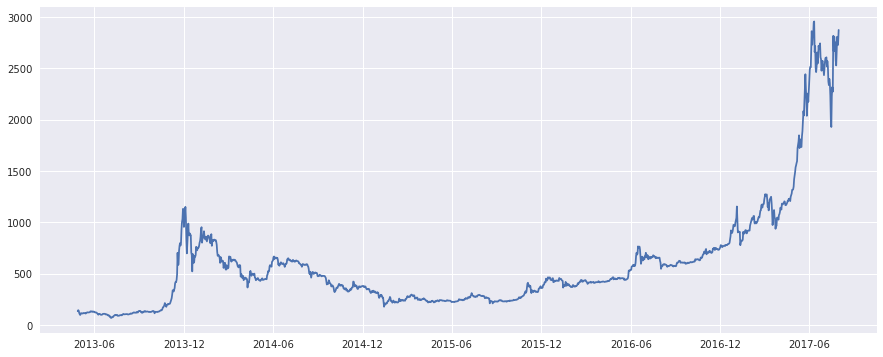

In [18]:
plt.plot(ts)

This part is inspired by: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ 

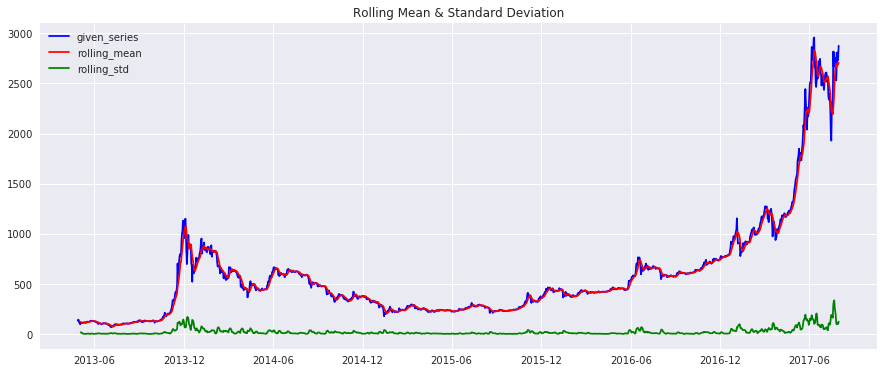

Results of Dickey-Fuller Test:
Test Statistic                    2.535589
p-value                           0.999060
#Lags Used                       24.000000
Number of Observations Used    1531.000000
Critical Value (1%)              -3.434628
Critical Value (5%)              -2.863430
Critical Value (10%)             -2.567776
dtype: float64


In [19]:
from statsmodels.tsa.stattools import adfuller
def test_for_stationary(input_data):
    r_mean = input_data.rolling(window = 7,center=False).mean()
    r_std = input_data.rolling(window = 7,center=False).std()
    
    # plotting the data
    given = plt.plot(input_data, color = 'blue', label = 'given_series')
    rolling_mean = plt.plot(r_mean, color = 'red', label = 'rolling_mean')
    rolling_std = plt.plot(r_std, color ='green', label = 'rolling_std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
     #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(input_data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
      
test_for_stationary(ts)   

### The test statistic is very large compared to the crtical value. The above series show that rolling mean value varies  with time and is not stationary. The series needs to be Stationarized. we need to eliminate the trend and seasonality from the series to make it stationary


# Transforming the data - (to eliminate trend)

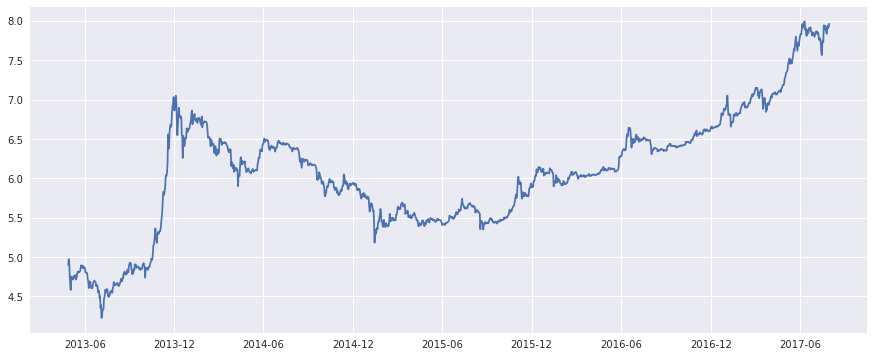

In [20]:
ts_logtransformed = np.log(ts)
plt.plot(ts_logtransformed)

In [21]:
ts_logtransformed.head(10)

Date
2013-04-28    4.899406
2013-04-29    4.973556
2013-04-30    4.934474
2013-05-01    4.762088
2013-05-02    4.655958
2013-05-03    4.582413
2013-05-04    4.722953
2013-05-05    4.752814
2013-05-06    4.721174
2013-05-07    4.714025
Name: Close, dtype: float64

# Smoothing by Rolling average

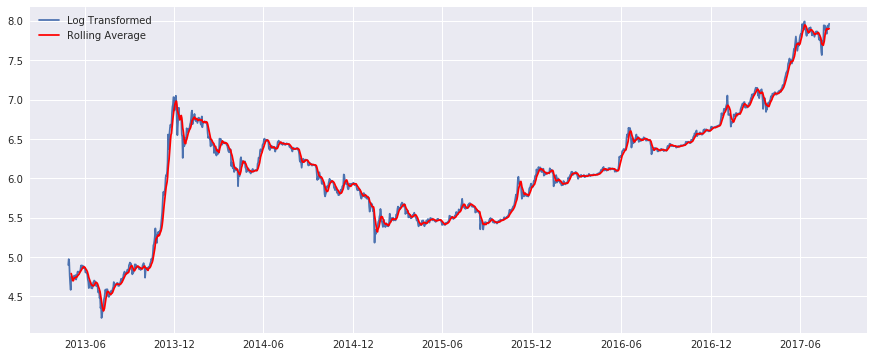

In [22]:
Rolling_average = ts_logtransformed.rolling(window = 7, center= False).mean()
plt.plot(ts_logtransformed, label = 'Log Transformed')
plt.plot(Rolling_average, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')


The red line shows the rolling mean. Note that since we are taking average of last 7 values, rolling mean is not defined for first 7 values. This can be observed as:

In [23]:
Rolling_average.head(10)

Date
2013-04-28         NaN
2013-04-29         NaN
2013-04-30         NaN
2013-05-01         NaN
2013-05-02         NaN
2013-05-03         NaN
2013-05-04    4.790121
2013-05-05    4.769180
2013-05-06    4.733125
2013-05-07    4.701632
Name: Close, dtype: float64

 Lets subtract this Rolling average this from the original log transfomred series.

In [24]:
log_Rolling_difference = ts_logtransformed - Rolling_average
log_Rolling_difference.head(10)
log_Rolling_difference.tail(10)

Date
2017-07-22    0.151593
2017-07-23    0.073239
2017-07-24    0.051861
2017-07-25   -0.030130
2017-07-26   -0.063797
2017-07-27   -0.001463
2017-07-28    0.041254
2017-07-29    0.015741
2017-07-30    0.025554
2017-07-31    0.061402
Name: Close, dtype: float64

 Replace NAN with 0 in the above dataframe to avoid any errors in the future. 

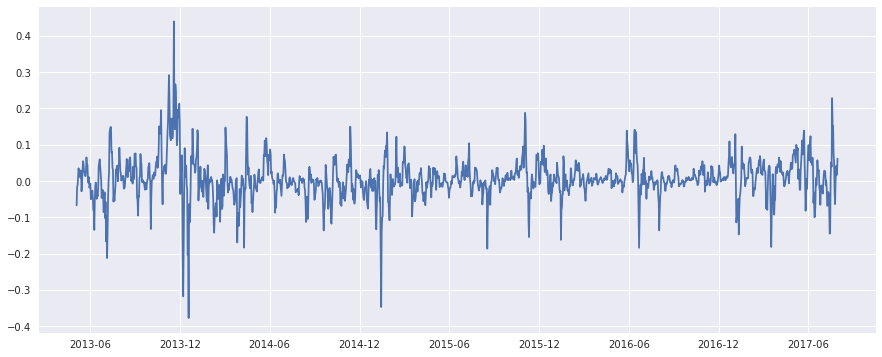

In [25]:
log_Rolling_difference.dropna(inplace=True)
plt.plot(log_Rolling_difference)

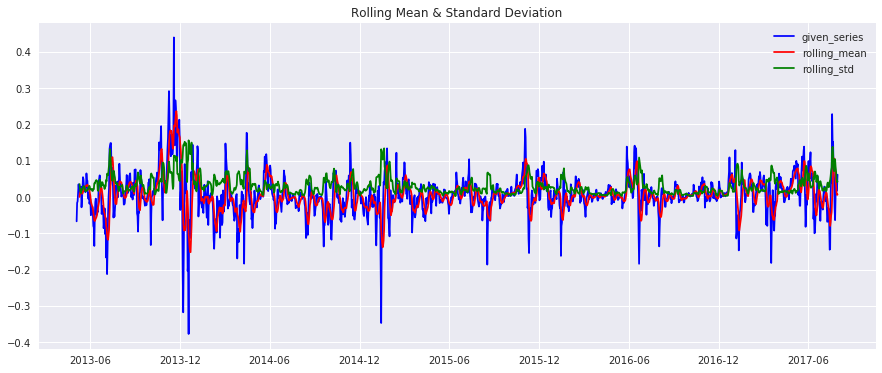

Results of Dickey-Fuller Test:
Test Statistic                -7.191326e+00
p-value                        2.499260e-10
#Lags Used                     2.200000e+01
Number of Observations Used    1.527000e+03
Critical Value (1%)           -3.434640e+00
Critical Value (5%)           -2.863435e+00
Critical Value (10%)          -2.567779e+00
dtype: float64


In [26]:
test_for_stationary(log_Rolling_difference)

Use exponential_weighted_moving_average instead of moving average to improve the solution

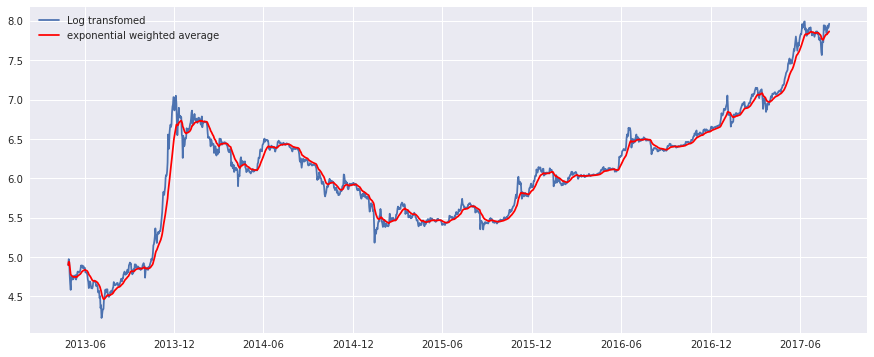

In [27]:
expwighted_avg = ts_logtransformed.ewm(halflife=7,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_logtransformed, label = 'Log transfomed')
plt.plot(expwighted_avg, color='red', label = 'exponential weighted average')
plt.legend(loc = 'best')

In [28]:
expwighted_avg.head(10)

Date
2013-04-28    4.899406
2013-04-29    4.938315
2013-04-30    4.936906
2013-05-01    4.886513
2013-05-02    4.830850
2013-05-03    4.778564
2013-05-04    4.768079
2013-05-05    4.765448
2013-05-06    4.758372
2013-05-07    4.751720
Name: Close, dtype: float64

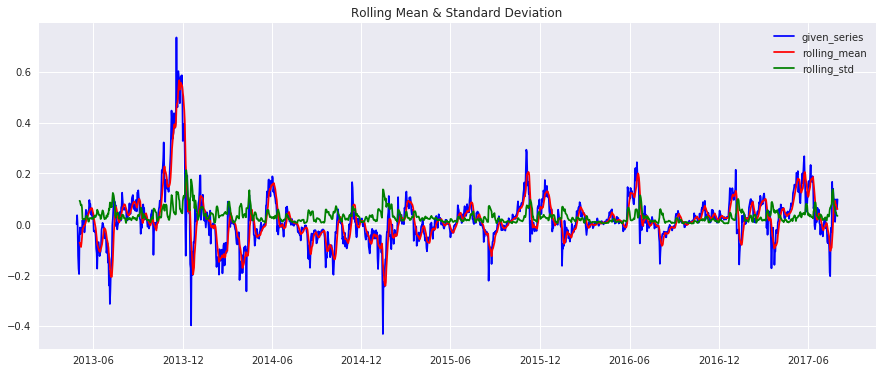

Results of Dickey-Fuller Test:
Test Statistic                   -5.442038
p-value                           0.000003
#Lags Used                       23.000000
Number of Observations Used    1532.000000
Critical Value (1%)              -3.434626
Critical Value (5%)              -2.863428
Critical Value (10%)             -2.567775
dtype: float64


In [29]:
log_expmovwt_diff = ts_logtransformed - expwighted_avg

test_for_stationary(log_expmovwt_diff)

Now the current time series is stationary,the TS (test_statistic) value is less than 1% critcal value. Since weights are assigned to values from the starting index. Therefore the test works  

Few other methods to eliminate Trend and seasonality.
Here i am implementing Differencing and Decompostion


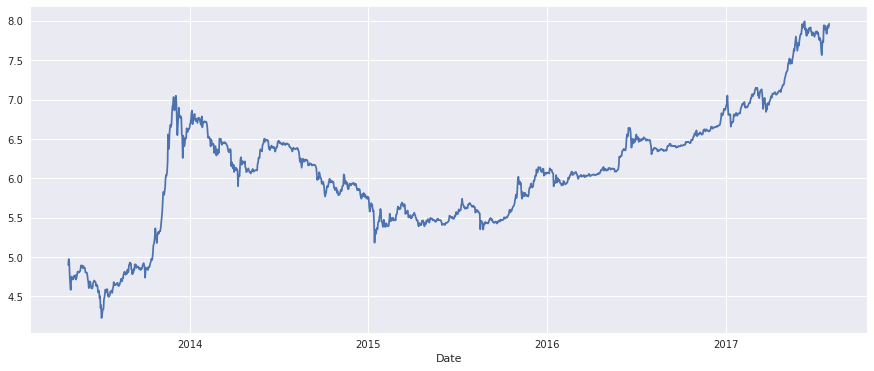

In [30]:
ts_logtransformed.plot()

## Seasonality Adjustment by Differencing
Seasonal components in a Time series can be elimnated by using differencing. If there is a seasonal component at level of one month, then it can be removed on an observation today by substracting the value from last month (Ex: Value(Oct 1)-Value(sep 1), value (oct 2 - Value(Sep 2),.....) We can substract last months data to the presents (giving a gap of 30 days) and first months data would not be available for modeling

I am trying to difference different types of seasonality and test for statioanarized data

In [31]:
#X = ts_logtransformed
#diff = list()
#days_in_quarter = 91
#for i in range(days_in_quarter, len(X)):
 #   value = X[i] - X[i - days_in_quarter]
#    diff.append(value)
#plt.plot(diff)
#diff = pd.Series(diff)
#diff
#plt.plot(diff)

Date
2013-04-28         NaN
2013-04-29         NaN
2013-04-30         NaN
2013-05-01         NaN
2013-05-02         NaN
2013-05-03         NaN
2013-05-04         NaN
2013-05-05   -0.146592
2013-05-06   -0.252382
2013-05-07   -0.220449
Name: Close, dtype: float64

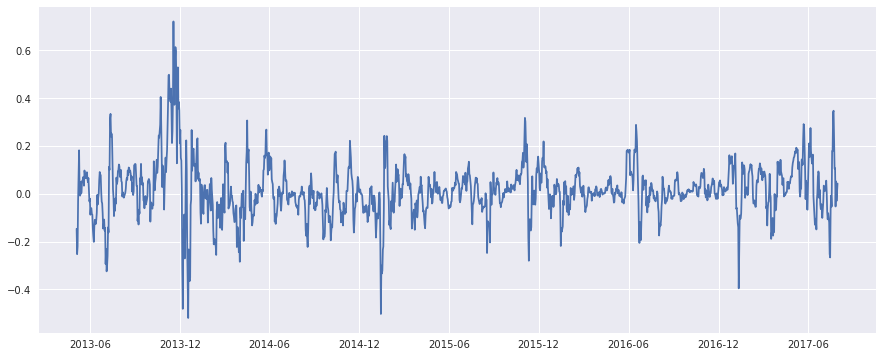

In [32]:
ts_diff_logtrans = ts_logtransformed -ts_logtransformed.shift(7)
plt.plot(ts_diff_logtrans)
ts_diff_logtrans.head(10)

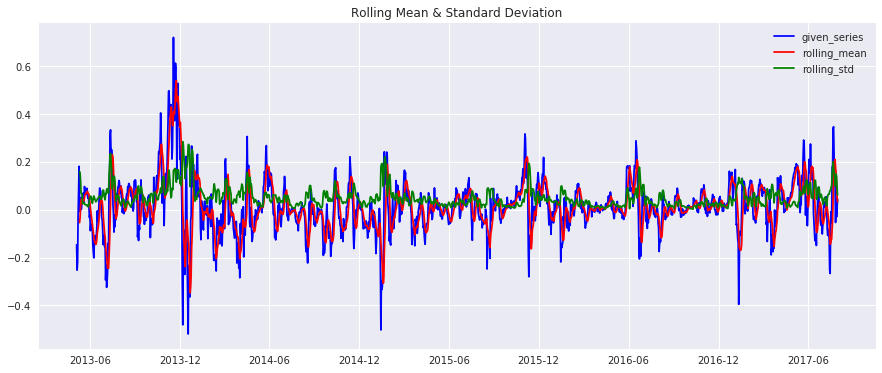

Results of Dickey-Fuller Test:
Test Statistic                -6.523574e+00
p-value                        1.027774e-08
#Lags Used                     2.300000e+01
Number of Observations Used    1.525000e+03
Critical Value (1%)           -3.434645e+00
Critical Value (5%)           -2.863437e+00
Critical Value (10%)          -2.567780e+00
dtype: float64


In [33]:
ts_diff_logtrans.dropna(inplace=True)
test_for_stationary(ts_diff_logtrans)

The Dickey-Fuller test statis is very much less than 1% criticasl value than in the previous case. We can say that the Time series is stationary with 99% confidence 

## Decomposing

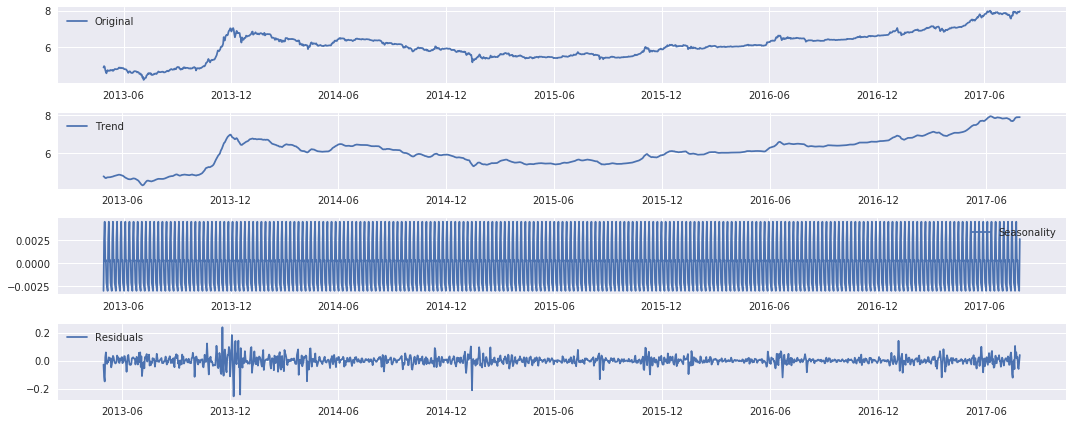

In [34]:
decomposition = seasonal_decompose(ts_logtransformed)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_logtransformed, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

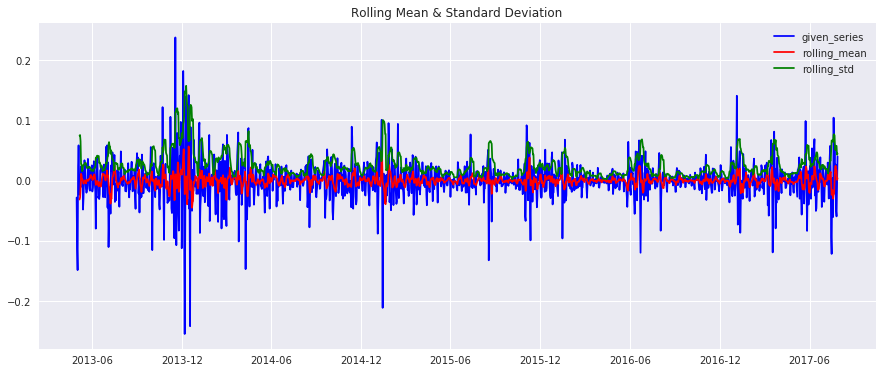

Results of Dickey-Fuller Test:
Test Statistic                -1.256779e+01
p-value                        2.035387e-23
#Lags Used                     2.300000e+01
Number of Observations Used    1.526000e+03
Critical Value (1%)           -3.434642e+00
Critical Value (5%)           -2.863436e+00
Critical Value (10%)          -2.567779e+00
dtype: float64


In [35]:
decomposed_TS = residual
decomposed_TS.dropna(inplace=True)
test_for_stationary(decomposed_TS)


# Forecasting

In [36]:
#ACF and PACF plots:
lag_acf = acf(ts_diff_logtrans, nlags=30)
lag_pacf = pacf(ts_diff_logtrans, nlags=50, method='ols')

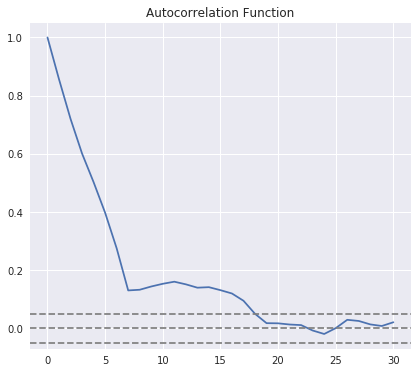

In [37]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff_logtrans)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff_logtrans)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

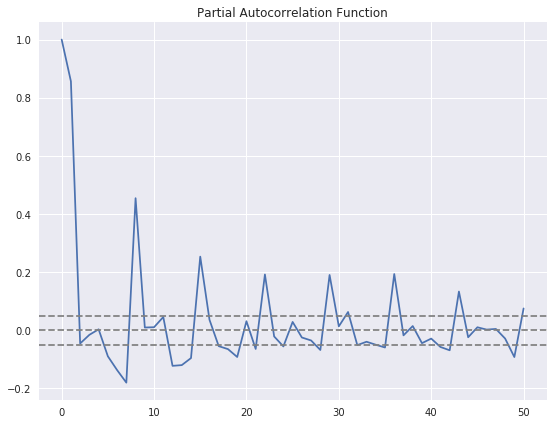

In [38]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff_logtrans)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff_logtrans)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

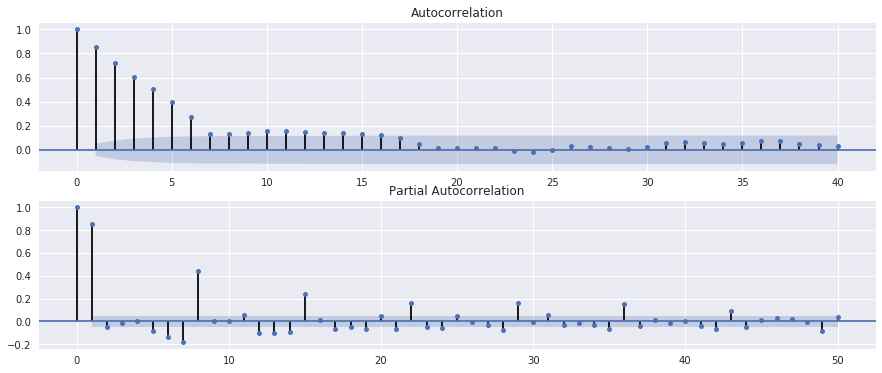

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts_diff_logtrans, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(ts_diff_logtrans, ax=pyplot.gca(), lags=50)
pyplot.show()

Below are some observations from the plots.

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:
the Lag values are identified from PACF and ACF plots for Autoregression(AR) and Moving Average(MA) parameters, p and q respectively
p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2, The PACF shows a significant lag on day 2 

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=18, since the ACF shows a significant lag for 18th day.

The PACF  perhaps has  some significant lag at 7th, 8th, 12th, 15th day and so on, which also suggests that there is still some seasonality present in the differenced data. We will try different orders of ARIMA models to identify the best order by deriving the residual sum of squares(RSS) for each model. Lower RSS are considered to be the best ones

In [40]:
from statsmodels.tsa.arima_model import ARIMA

In [41]:
ts_diff_logtrans = ts_diff_logtrans.fillna(0)

# AR Model

In [42]:
#model = ARIMA(ts_logtransformed, order=(20, 1, 0))  
#results_AR = model.fit(disp=-1)  
#plt.plot(ts_diff_logtrans)
#plt.plot(results_AR.fittedvalues, color='red', label = 'order 20')
#RSS = results_AR.fittedvalues-ts_diff_logtrans
#RSS.dropna(inplace=True)
#plt.title('RSS: %.4f'% sum(RSS**2))
#plt.legend(loc = 'best')

In [43]:
#model = ARIMA(ts_logtransformed, order=(15, 1, 0))  
#results_AR = model.fit(disp=-1)  
#plt.plot(ts_diff_logtrans)
#plt.plot(results_AR.fittedvalues, color='red', label = 'order 15')
#RSS = results_AR.fittedvalues-ts_diff_logtrans
#RSS.dropna(inplace=True)
#plt.title('RSS: %.4f'% sum(RSS**2))
#plt.legend(loc = 'best')

In [44]:
#model = ARIMA(ts_logtransformed, order=(12, 1, 0))  
#results_AR = model.fit(disp=-1)  
#plt.plot(ts_diff_logtrans)
#plt.plot(results_AR.fittedvalues, color='red', label = 'order 12')
#RSS = results_AR.fittedvalues-ts_diff_logtrans
#RSS.dropna(inplace=True)
#plt.title('RSS: %.4f'% sum(RSS**2))
#plt.legend(loc = 'best')

In [45]:
#model = ARIMA(ts_logtransformed, order=(7, 1, 0))  
#results_AR = model.fit(disp=-1)  
#plt.plot(ts_diff_logtrans)
#plt.plot(results_AR.fittedvalues, color='red', label = 'order 7')
#RSS = results_AR.fittedvalues-ts_diff_logtrans
#RSS.dropna(inplace=True)
#plt.title('RSS: %.4f'% sum(RSS**2))
#plt.legend(loc = 'best')

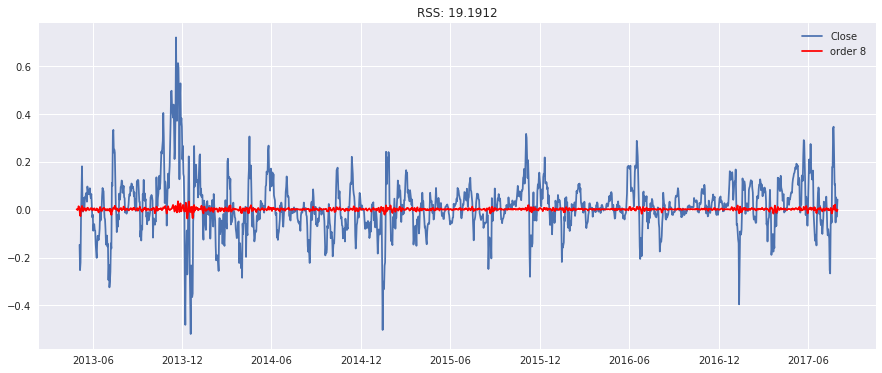

In [46]:
model = ARIMA(ts_logtransformed, order=(8, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_AR.fittedvalues, color='red', label = 'order 8')
RSS = results_AR.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc = 'best')

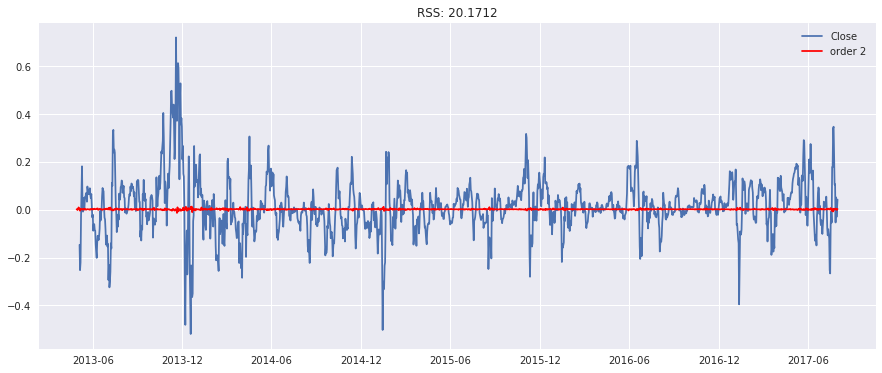

In [47]:
model = ARIMA(ts_logtransformed, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_AR.fittedvalues, color='red', label = 'order 2')
RSS = results_AR.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc ='best')



In [48]:
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1555
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2704.690
Method:                       css-mle   S.D. of innovations              0.042
Date:                Thu, 09 Nov 2017   AIC                          -5401.380
Time:                        16:51:17   BIC                          -5379.984
Sample:                    04-29-2013   HQIC                         -5393.424
                         - 07-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      1.908      0.057   -5.37e-05       0.004
ar.L1.D.Close    -0.0011      0.025     -0.044      0.965      -0.051       0.049
ar.L2.D.Close    -0.0435      0.025     

# MA model

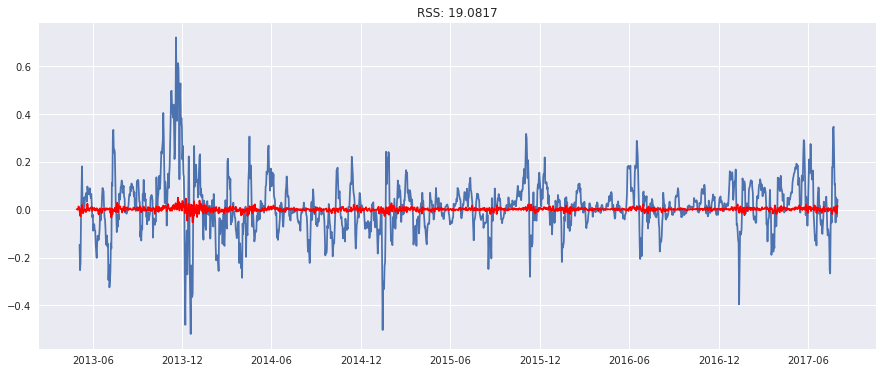

In [49]:
model = ARIMA(ts_logtransformed, order=(0, 1,18)) 
results_MA = model.fit(disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_MA.fittedvalues, color='red')
RSS = results_MA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))


In [50]:
#model summary
print(results_MA.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1555
Model:                ARIMA(0, 1, 18)   Log Likelihood                2727.323
Method:                       css-mle   S.D. of innovations              0.042
Date:                Thu, 09 Nov 2017   AIC                          -5414.646
Time:                        16:54:32   BIC                          -5307.661
Sample:                    04-29-2013   HQIC                         -5374.862
                         - 07-31-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0019      0.001      1.374      0.169      -0.001       0.005
ma.L1.D.Close     -0.0100      0.026     -0.390      0.697      -0.060       0.040
ma.L2.D.Close     -0.0373      0.025

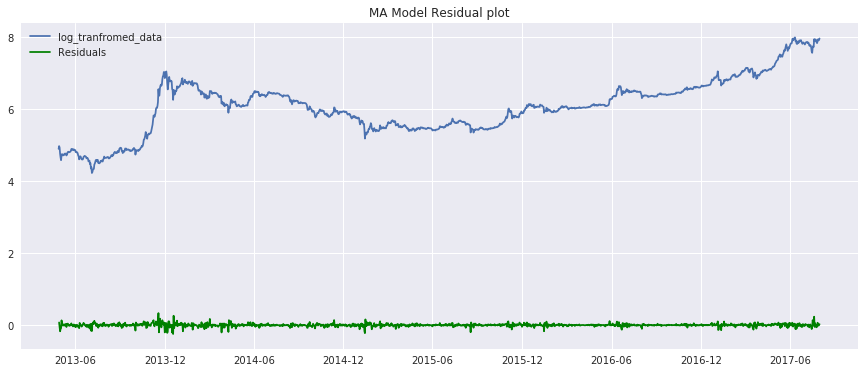

In [51]:
plt.plot(ts_logtransformed, label = 'log_tranfromed_data')
plt.plot(results_MA.resid, color ='green',label= 'Residuals')
plt.title('MA Model Residual plot')
plt.legend(loc = 'best')

count    1555.000000
mean        0.000053
std         0.041911
min        -0.246817
25%        -0.013552
50%         0.000411
75%         0.015719
max         0.332676
dtype: float64


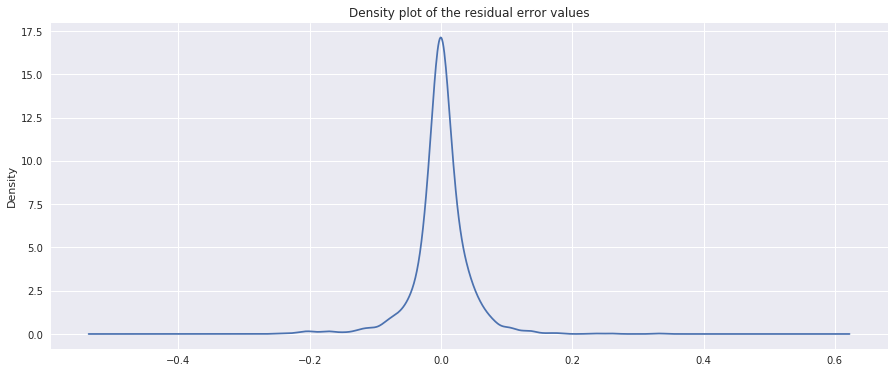

In [52]:
results_MA.resid.plot(kind='kde')
plt.title('Density plot of the residual error values')
print(results_MA.resid.describe())

# ARIMA Combined model

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


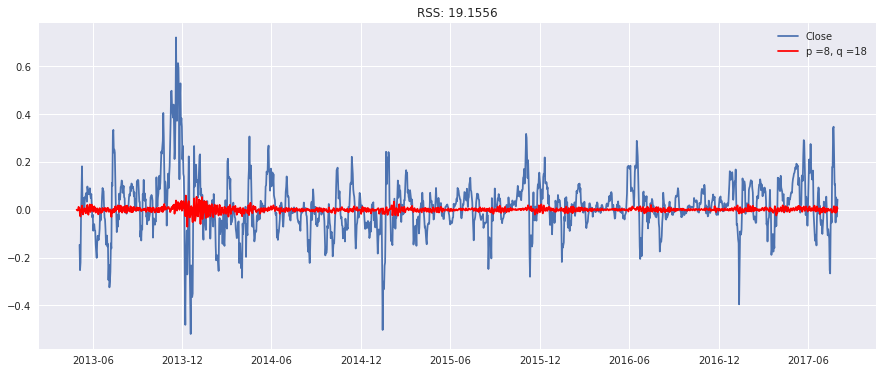

In [53]:
model = ARIMA(ts_logtransformed, order=(8, 1, 18))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =8, q =18')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')

model = ARIMA(ts_logtransformed, order=(20, 1, 18)) 
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'order 15')
RSS = results_ARIMA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc = 'best')

### Searching ARIMA parameters.
The above plots and models derive varying residual RSS. evaluating all these models might be difficult. SO we do a grid search on all possible ARIMA parameters. We look for different p,d,q combinations, and find the best combination.
p = 7 ,10,13,16,19
d = 0 to 2
taking 10 runs of the model and this will take some time to run

The following markdown is a python code that helps to evaluate different model performances to evaluate best ARIMA hyperparameters

import warnings
def evaluate_arima_model(data_set, arima_order):
    model = ARIMA(data_set, order=arima_order)
    results_ARIMA = model.fit(disp=-1) 
    RSS_diff = results_ARIMA.fittedvalues-ts_diff_logtrans
    RSS = RSS_diff**2
    return RSS
def evaluate_models(dataset, p_values, d_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            order = (p,d,18)
            try:
                rss = evaluate_arima_model(dataset, order)
                if rss < best_score:
                    best_score, best_cfg = rss, order
                print('ARIMA%s RSS=%.3f' % (order,rss))
            except:
                continue
    print('Best ARIMA%s RSS=%.3f' % (best_cfg, best_score))
p_values = range(8,20,3)
d_values = range(0,3)
warnings.filterwarnings('ignore')
evaluate_models(ts_logtransformed,p_values,d_values)

We can derive the Summary of the ARIMA model as follows explaining the results

In [54]:
#model summary
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1555
Model:                ARIMA(8, 1, 18)   Log Likelihood                2740.102
Method:                       css-mle   S.D. of innovations              0.042
Date:                Thu, 09 Nov 2017   AIC                          -5426.203
Time:                        17:04:50   BIC                          -5281.774
Sample:                    04-29-2013   HQIC                         -5372.495
                         - 07-31-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ar.L1.D.Close     -0.7103        nan        nan        nan         nan         nan
ar.L2.D.Close     -0.7247        nan        nan        nan         nan         nan
ar.L3.D.Close     -1.3433      0.134

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


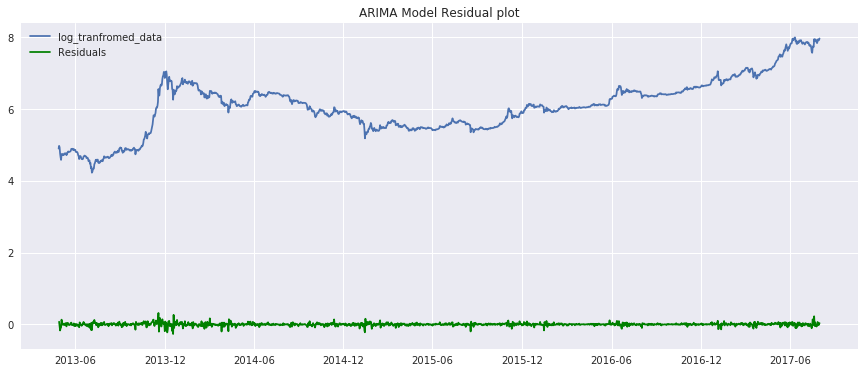

In [55]:
plt.plot(ts_logtransformed, label = 'log_tranfromed_data')
plt.plot(results_ARIMA.resid, color ='green',label= 'Residuals')
plt.title('ARIMA Model Residual plot')
plt.legend(loc = 'best')

count    1555.000000
mean        0.001535
std         0.041545
min        -0.266411
25%        -0.012498
50%         0.001836
75%         0.017867
max         0.318732
dtype: float64


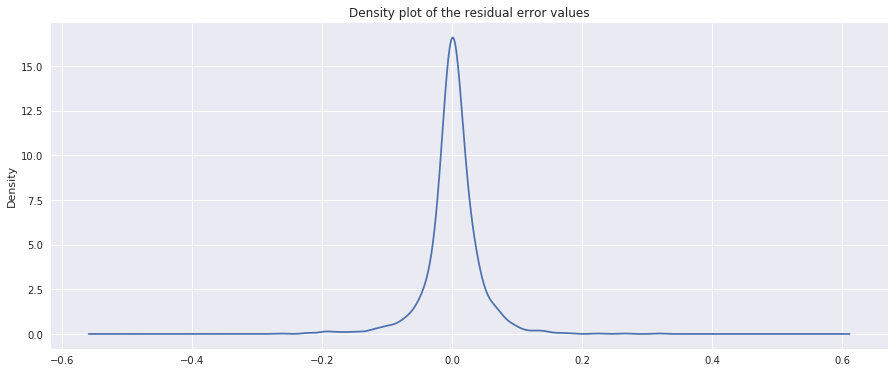

In [56]:
results_ARIMA.resid.plot(kind='kde')
plt.title('Density plot of the residual error values')
print(results_ARIMA.resid.describe())

In [57]:
test = pd.read_csv("../input/bitcoin_price_1week_Test - Test.csv",index_col= 'Date')
test.index = pd.to_datetime(test.index)
test = test['Close']
test = test.sort_index()
test

Date
2017-08-01    2718.26
2017-08-02    2710.67
2017-08-03    2804.73
2017-08-04    2895.89
2017-08-05    3252.91
2017-08-06    3213.94
2017-08-07    3378.94
Name: Close, dtype: float64

## Using Combined ARIMA model to predict and forecast

In [58]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2013-04-29    0.000000
2013-04-30    0.000214
2013-05-01   -0.003366
2013-05-02   -0.000140
2013-05-03    0.012158
dtype: float64


In [59]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Date
2013-04-29    0.000000
2013-04-30    0.000214
2013-05-01   -0.003152
2013-05-02   -0.003292
2013-05-03    0.008866
dtype: float64


In [60]:
predictions_ARIMA_log = pd.Series(ts_logtransformed.iloc[0], index=ts_logtransformed.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2013-04-28    4.899406
2013-04-29    4.899406
2013-04-30    4.899620
2013-05-01    4.896254
2013-05-02    4.896114
dtype: float64

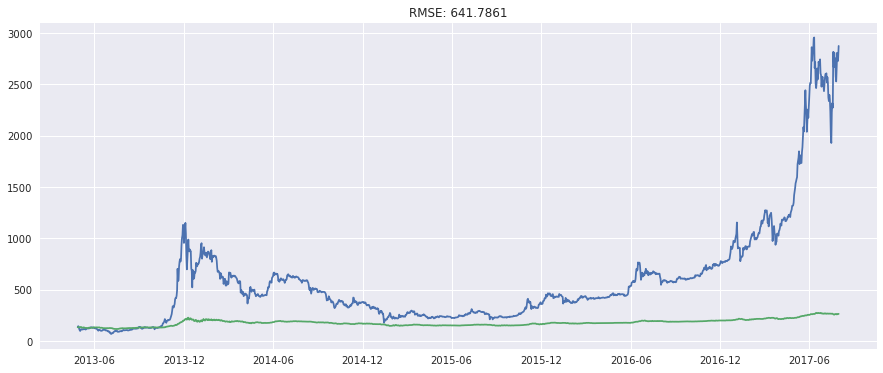

In [61]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))

In [62]:
dates = [pd.Timestamp('2017-08-01'), pd.Timestamp('2017-08-02'), pd.Timestamp('2017-08-03'),pd.Timestamp('2017-08-04'), pd.Timestamp('2017-08-05'), pd.Timestamp('2017-08-06'), pd.Timestamp('2017-08-07')]

forecast = pd.Series(results_ARIMA.forecast(steps=7)[0],dates)
forecast = np.exp(forecast)
print(forecast)
error = mean_squared_error(test, forecast)
print('Test MSE: %.3f' % error)

2017-08-01    2871.243213
2017-08-02    2940.699509
2017-08-03    2989.790766
2017-08-04    3016.172986
2017-08-05    2953.217515
2017-08-06    2948.120379
2017-08-07    2983.645389
dtype: float64
Test MSE: 63109.487


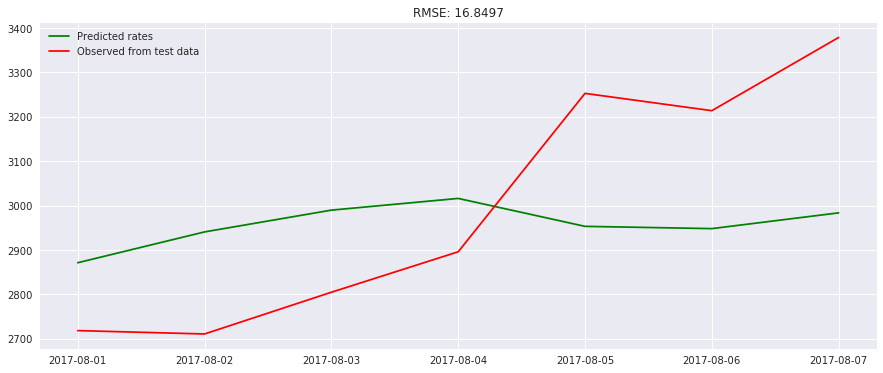

In [63]:
plt.plot(forecast, color ='green', label ='Predicted rates')
plt.plot(test, color = 'red', label = 'Observed from test data')
plt.title('RMSE: %.4f'% np.sqrt(sum((forecast-test)**2)/len(data)))
plt.legend(loc = 'best')

## Using MA model to predict and forecast

Here we can see that the AR and MA, and the combined ARIMA models have almost the same RSS but MA model is significantly better in computational performance. So we use it to predict the price.



In [64]:
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
print(predictions_MA_diff.head())

Date
2013-04-29    0.001941
2013-04-30    0.001458
2013-05-01    0.000081
2013-05-02    0.002704
2013-05-03    0.013811
dtype: float64


In [65]:
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
print(predictions_MA_diff_cumsum.head())

Date
2013-04-29    0.001941
2013-04-30    0.003399
2013-05-01    0.003479
2013-05-02    0.006184
2013-05-03    0.019995
dtype: float64


Notice that the predictions arent starting from 2013-04-28. This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number

In [66]:
predictions_MA_log = pd.Series(ts_logtransformed.iloc[0], index=ts_logtransformed.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)
predictions_MA_log.head()

Date
2013-04-28    4.899406
2013-04-29    4.901347
2013-04-30    4.902805
2013-05-01    4.902885
2013-05-02    4.905590
dtype: float64

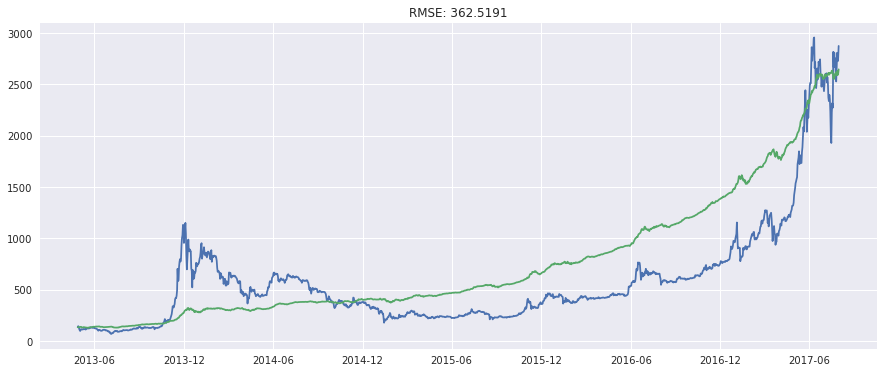

In [67]:
predictions_MA = np.exp(predictions_MA_log)
plt.plot(data)
plt.plot(predictions_MA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_MA-data)**2)/len(data)))

In [68]:
dates = [pd.Timestamp('2017-08-01'), pd.Timestamp('2017-08-02'), pd.Timestamp('2017-08-03'),pd.Timestamp('2017-08-04'), pd.Timestamp('2017-08-05'), pd.Timestamp('2017-08-06'), pd.Timestamp('2017-08-07')]

forecast = pd.Series(results_MA.forecast(steps=7)[0],dates)
forecast = np.exp(forecast)
print(forecast)
error = mean_squared_error(test, forecast)
print('Test MSE: %.3f' % error)

2017-08-01    2873.760745
2017-08-02    2933.263142
2017-08-03    2985.843997
2017-08-04    3001.085178
2017-08-05    2982.756158
2017-08-06    3057.337950
2017-08-07    3063.277789
dtype: float64
Test MSE: 44963.775


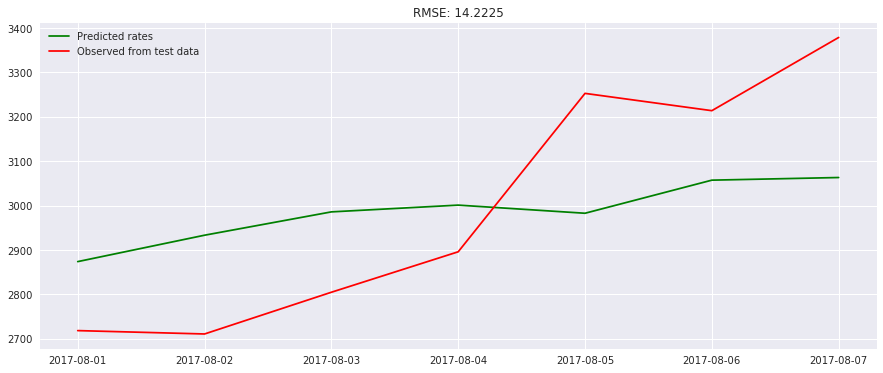

In [69]:
plt.plot(forecast, color ='green', label ='Predicted rates')
plt.plot(test, color = 'red', label = 'Observed from test data')
plt.title('RMSE: %.4f'% np.sqrt(sum((forecast-test)**2)/len(data)))
plt.legend(loc = 'best')

Much work has to be done on eliminating hte seasonality in the above time series. More methods licke curve fitting and differnce can be extended to identify seasonality and remove the seasonal component from the data.

An improved model may be to subtract the average coin price from the same calendar month in the previous year, rather than the same day.

We can start off by resampling the dataset to a monthly average price. The resampling methods handles the concept of leap years while eliminating the offset  (for example feb has only 28 days ). 

Date
2013-04-30    139.250000
2013-05-31    119.993226
2013-06-30    107.761333
2013-07-31     90.512258
2013-08-31    113.905161
2013-09-30    130.061667
2013-10-31    158.311935
2013-11-30    550.420667
2013-12-31    800.780968
2014-01-31    844.168387
2014-02-28    661.618214
2014-03-31    592.200323
2014-04-30    461.362000
Freq: M, Name: Close, dtype: float64


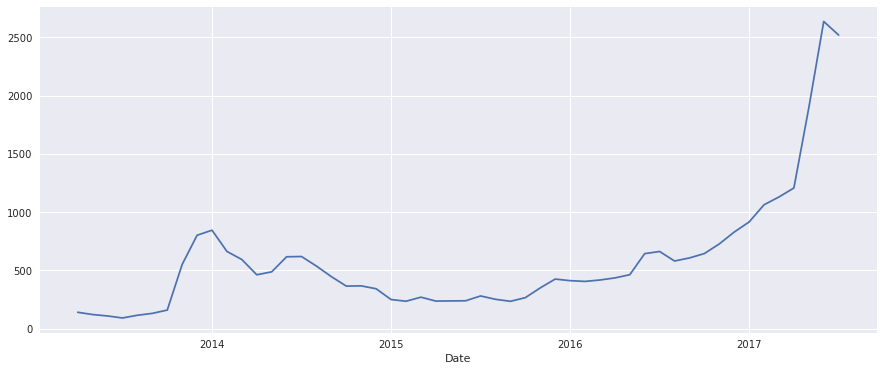

In [70]:
monthly_mean = data.resample('M').mean()
monthly_mean
print(monthly_mean.head(13))
monthly_mean.plot()

## One more alternative to derive the forecasting performance

In [71]:
test_logtransformed = np.log(test)

In [72]:
history = [x for x in ts_logtransformed]
predictions = list()
for t in range(len(test)):
    output = results_MA.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_logtransformed[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_logtransformed, predictions)
print('Test MSE: %.3f' % error)


predicted=7.963377, expected=7.907747
predicted=7.963377, expected=7.904951
predicted=7.963377, expected=7.939063
predicted=7.963377, expected=7.971048
predicted=7.963377, expected=8.087305
predicted=7.963377, expected=8.075253
predicted=7.963377, expected=8.125317
Test MSE: 0.009


Much work has to be done on eliminating hte seasonality in the above time series. More methods licke curve fitting and differnce can be extended to identify seasonality and remove the seasonal component from the data.

An improved model may be to subtract the average coin price from the same calendar month in the previous year, rather than the same day.

We can start off by resampling the dataset to a monthly average price. The resampling methods handles the concept of leap years while eliminating the offset  (for example feb has only 28 days ). 

In [73]:
from fbprophet import Prophet

In [74]:
data.head()

Date
2013-04-28    134.21
2013-04-29    144.54
2013-04-30    139.00
2013-05-01    116.99
2013-05-02    105.21
Name: Close, dtype: float64

In [75]:
data_prophet = data.copy()
data_prophet = pd.DataFrame(data_prophet)
data_prophet.reset_index(drop=False, inplace=True)
data_prophet.columns =['ds','y']
data_prophet

,ds,y
0,2013-04-28,134.21
1,2013-04-29,144.54
2,2013-04-30,139.00
3,2013-05-01,116.99
4,2013-05-02,105.21
5,2013-05-03,97.75
6,2013-05-04,112.50
7,2013-05-05,115.91
8,2013-05-06,112.30
9,2013-05-07,111.50


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


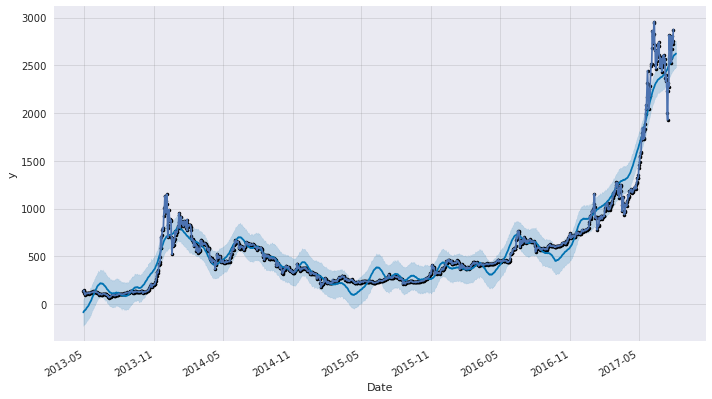

In [76]:
m = Prophet()
m.fit(data_prophet)
future = m.make_future_dataframe(periods=7, freq='D')
forecast = m.predict(future)
m.plot(forecast)
data.plot()


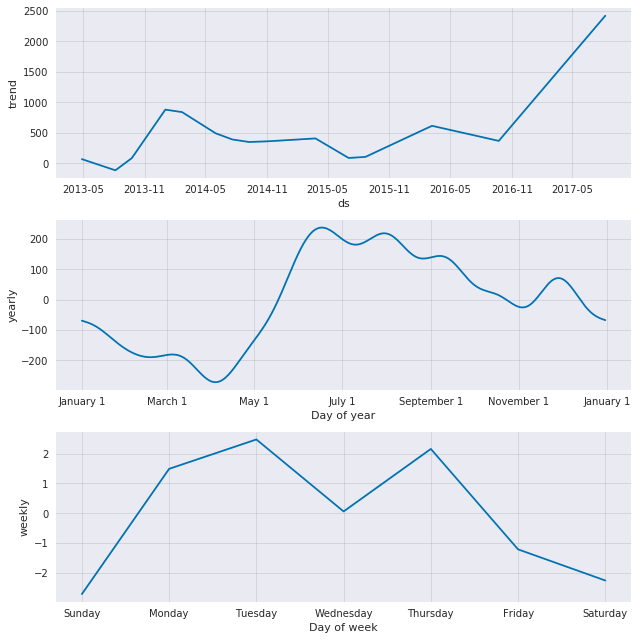

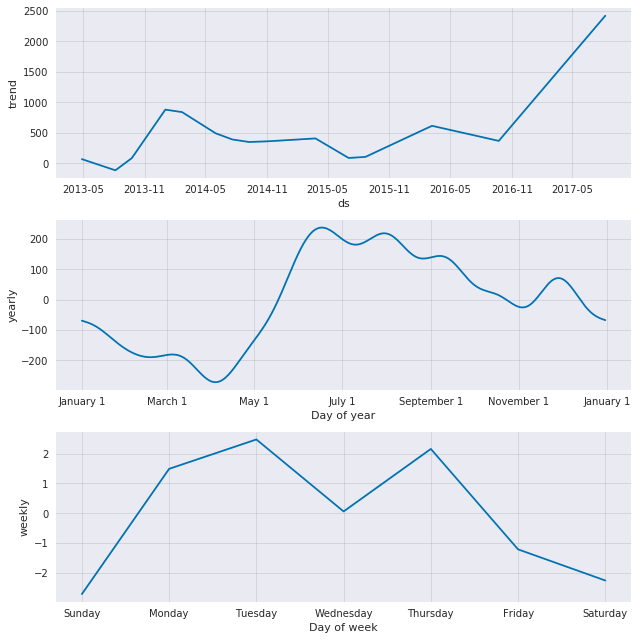

In [77]:
m.plot_components(forecast)

In [78]:
forecast.columns

Index(['ds', 'trend', 'trend_lower', 'trend_upper', 'yhat_lower', 'yhat_upper',
       'seasonal', 'seasonal_lower', 'seasonal_upper', 'seasonalities',
       'seasonalities_lower', 'seasonalities_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'yhat'],
      dtype='object')

In [79]:
forecasted_values = forecast[['ds', 'yhat']].tail(7)

In [80]:
forecasted_values = forecasted_values.set_index('ds')
forecasted_values.columns = ['y']
forecasted_values

,y
ds,
2017-08-01,2602.223972
2017-08-02,2604.963379
2017-08-03,2611.660358
2017-08-04,2612.358183
2017-08-05,2614.868733
2017-08-06,2617.494982
2017-08-07,2624.347313


In [81]:
mean_squared_error(forecasted_values['y'],test)

210651.12399157134

## RNN

- In Progress

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

The Model needs further  improvement. Will have to work on few other approaches such as Facebooks Prophet approach and Keras Starter. Much information on theses approaches can be found on https://research.fb.com/prophet-forecasting-at-scale/ and https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
